In [1]:
# For each time point use the overlapping DE genes of mof and prdx1 (extract from time_up_n_down) 
# to find kegg pathways using enricher (and)or clusterProfiler
# background: all DE genes `time_all_diffs.tsv` (or all genes??)

In [2]:
import pandas as pd
import gseapy as gp
from gseapy.parser import Biomart
import matplotlib.pyplot as plt
import os
import gffutils
import glob
import numpy as np

In [3]:
# paths
in_path = os.path.join("/data/processing1/leily/deseq_pairwise/fdr0.05")
out_path = os.path.join("/data/processing1/leily/deseq_pairwise/fdr0.05/enrichment_analysis")

In [4]:
# convert IDs using biomart
bm = Biomart()
genes_names = pd.read_csv(os.path.join(in_path, "gsea", "gene_id_ensembl.tsv"), sep = "\t")
queries = genes_names["gene_id"].values.tolist() # need to be a python list
print(len(queries))
results = bm.query(dataset='mmusculus_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id'],
                   filters={'ensembl_gene_id': queries})

47937


In [5]:
# enricher

In [6]:
up_dfs = dict()
down_dfs = dict()
for time in ["lps0", "lps3", "lps12"]:
    for file in glob.glob(os.path.join(in_path, time+"_up_n_down.tsv")):
        df = pd.read_csv(file, sep = "\t")
        df.rename(columns={'gene_name':'external_gene_name'}, inplace = True)
        cols = [i for i in df.columns[1:-1]]
        merged_df = df.merge(results, on = "external_gene_name", how = "inner")
        if time not in up_dfs.keys():
            up_dfs[time] = []
            down_dfs[time] = []
            
        up_dfs[time].append(df.loc[(df[cols[0]] == "UP") & (df[cols[1]] == "UP")])
        down_dfs[time].append(df.loc[(df[cols[0]] == "DOWN") & (df[cols[1]] == "DOWN")])

print("down:")
for k, v in down_dfs.items():
    print(k, len(v[0]))

print("up:")
for k, v in up_dfs.items():
    print(k, len(v[0]))

down:
lps0 733
lps3 1806
lps12 989
up:
lps0 443
lps3 1432
lps12 606


In [7]:
#Get the rows of time_all_diffs.tsv where at least one of the columns is not nan, add their external gene name
db = gffutils.FeatureDB(os.path.join(in_path, "grcm38.db"))
bg = dict()
for time in ["lps0", "lps3", "lps12"]:
    df = pd.read_csv(os.path.join(in_path,time+"_all_diffs.tsv"), sep = "\t", na_values = "NaN")
    print(len(df))
    cols = [i for i in df.columns[1:]]
    df = df.loc[(df[cols[0]].astype(str) != "nan") | (df[cols[1]].astype(str) != "nan")]
    print(len(df))
    names = []
    for index, row in df.iterrows():
        gene_id = row['gene_id']
        try:
            gene = db[gene_id]
            name = gene.attributes['gene_name']
            names.append(name[0])
        except:
            print("name not found!")
            names.append("no_name")
    df['gene_name'] = names
    bg[time] = df

47937
8593
47937
10047
47937
8576


In [8]:
# enricher uses its own back ground in the online mode, so there is no reason to rpovide any background here.
# It is not used anyway.
for time in ["lps0", "lps3", "lps12"]:
    for df in up_dfs[time]:
        print(df["external_gene_name"].head())
        print(bg[time]["gene_name"].head())
        enr = gp.enrichr(gene_list=df["external_gene_name"].astype(str),
                         description=time+"_up",
                         gene_sets='KEGG_2019_Mouse',
#                          background= bg[time]["gene_name"].astype(str), 
                         outdir=os.path.join(out_path,'enricher_report_kegg_2019_'+time+"_up"),
                         cutoff=0.05, # only used for ploting.
                         organism='Mouse',
                         verbose=False)
#         dotplot(enr.res2d, title='KEGG_2019_Mouse',cmap='viridis_r')

1     Prdx1
2     Cyb5b
4    Mapre1
6      Xpot
8     Stmn1
Name: external_gene_name, dtype: object
0     Akr1a1
1      Prdx1
2    Dnajc14
3      Cyb5b
4     Pabpc1
Name: gene_name, dtype: object


2021-09-03 11:19:53,040 Warning: No enrich terms using library KEGG_2019_Mouse when cutoff = 0.05


0    Rab11fip1
2        Traf1
5        Ptgs2
7       Adgrl2
9        Malt1
Name: external_gene_name, dtype: object
0    Rab11fip1
1          Lox
2        Traf1
3         Bin2
4         Pon2
Name: gene_name, dtype: object
0      Stmn1
13      Ttc7
15      Lsp1
17    Mapre1
18     Uhmk1
Name: external_gene_name, dtype: object
0     Prdx1
1     Stmn1
2    Akr1a1
3     Ampd3
4      Xpot
Name: gene_name, dtype: object


In [9]:
for time in ["lps0", "lps3", "lps12"]:
    for df in down_dfs[time]:
        enr = gp.enrichr(gene_list=df["external_gene_name"].astype(str),
                         description=time+"_down",
                         gene_sets='KEGG_2019_Mouse',
#                          background= bg[time]["gene_name"].astype(str), 
                         outdir=os.path.join(out_path,'enricher_report_kegg_2019_'+time+"_down"),
                         cutoff=0.05, # only used for ploting.
                         organism='Mouse',
                         verbose=False)

In [10]:
# heatmap of log2(FC) on the selected pathways genes (TNF signaling pathway, NF-kappa B signaling pathway)

In [6]:
gene_name_df = pd.read_csv("/data/processing1/leily/deseq_pairwise/fdr0.05/gsea/kegg_name.tsv", sep ="\t")
tnf_pathway = ["CSF2", "TNFAIP3", "CXCL1", "NOD2", "CXCL3", "PTGS2", "TNF", "CXCL2", "RELA",
               "ICAM1", "IKBKB", "RPS6KA5", "CREB3L2", "JUNB", "MAP3K5", "VCAM1", "JAG1", "TRAF1",
               "CFLAR", "NFKB1", "NFKBIA", "CXCL10", "IL6", "IL1B", "IRF1", "BCL3", "TAB3", "FAS", "BIRC3"]

kappaB_pathway = ["NFAIP3", "PTGS2", "TNF", "CXCL2", "RELA", "MALT1", "ICAM1", "RELB", "IKBKB", "PLAU",
                  "CD14", "ERC1", "BCL2A1B", "VCAM1", "CSNK2A1", "GADD45B", "SYK", "CSNK2A2", "TRAF1",
                  "CFLAR", "NFKB1", "NFKB2", "NFKBIA", "IL1B", "TAB3", "BIRC3"]
steroid_pathway = ["SQLE","SC5D","DHCR24","MSMO1","DHCR7","HSD17B7","CYP51","FDFT1"]
cell_cycle_pathway = ["MCM7", "PLK1", "BUB1B", "CDC20", "ORC5", "CCNA2", "RBL2",
                      "CCNB2", "CDC23", "TFDP1", "TFDP2", "CCNE1", "RAD21","CDK1",
                      "MCM3", "E2F2", "ANAPC5", "MCM5", "SKP2", "ANAPC1", "MAD2L1"]

In [12]:
# 1) kappaB
kappaB_ensemble = gene_name_df.loc[gene_name_df["external_gene_name"].str.upper().isin(kappaB_pathway)]
kappaB_ensemble = kappaB_ensemble[["ensembl_gene_id", "ensembl_gene_id_version", "external_gene_name"]]
print(len(kappaB_ensemble))

25


In [13]:
all_dfs = dict()
for time in ["lps0", "lps3", "lps12"]:
    for cond in ["shmof", "shprdx1"]:
        for file in glob.glob(os.path.join(in_path, "ddr_"+time+"_shctrl_"+time+"_"+cond+"*.tsv")):
            print(file)
            df = pd.read_csv(file, sep = "\t")
            df['ensembl_gene_id'] = df['gene_id'].str.split('.', 1).str[0]
            df = df.merge(kappaB_ensemble, how = "inner", on = "ensembl_gene_id")
            df.sort_values(by=['external_gene_name'], inplace = True)
            if time not in all_dfs.keys():
                all_dfs[time] = []            
            all_dfs[time].append(df)

/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shprdx1.filtered.tsv


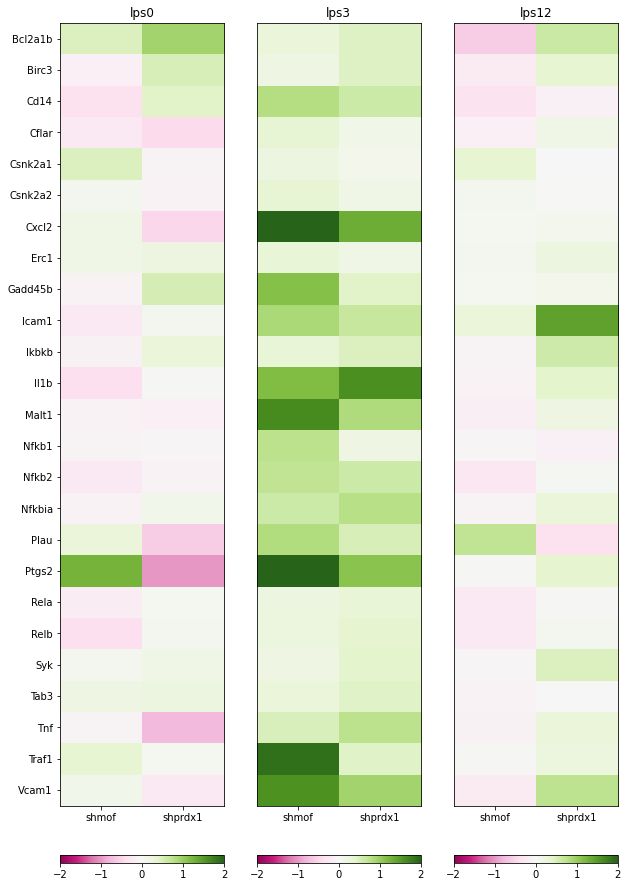

In [14]:
previous_names = np.array([])
df_to_write = pd.DataFrame()
fig, ax = plt.subplots(ncols=3)
for i, (k, v) in enumerate(all_dfs.items()):
    
    df_to_write[k+"_shmof"] = v[0]["log2FoldChange"].values
    df_to_write[k+"_shprdx1"] = v[1]["log2FoldChange"].values
    
    values = np.array([v[0]["log2FoldChange"].values, v[1]["log2FoldChange"].values])
    comparison = v[0]["external_gene_name"].values == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    
    previous_names = v[0]["external_gene_name"].values
    comparison = previous_names == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    im = ax[i].imshow(values.transpose(), interpolation='nearest', aspect='auto', vmin = -2,
                      vmax = 2, cmap='PiYG')
    
    if i == 0:
        ax[i].set_yticks(np.arange(len(previous_names)))
        ax[i].set_yticklabels(previous_names)
    else:
        ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(2))
    ax[i].set_xticklabels(["shmof", "shprdx1"])
    ax[i].set_title(k)
    fig.colorbar(im, ax = ax[i], orientation='horizontal', pad=0.05)
fig.set_size_inches(10,18)
plt.show()
fig.savefig(os.path.join(out_path, "kappab_pathway.pdf"))
df_to_write["gene_name"] = previous_names
df_to_write.to_csv(os.path.join(out_path, "kappab_pathway.tsv"), sep = "\t", index = None)

In [15]:
# 2) tnf pathway
tnf_ensemble = gene_name_df.loc[gene_name_df["external_gene_name"].str.upper().isin(tnf_pathway)]
tnf_ensemble = tnf_ensemble[["ensembl_gene_id", "ensembl_gene_id_version", "external_gene_name"]]
print(len(tnf_ensemble))

29


In [16]:
all_dfs = dict()
for time in ["lps0", "lps3", "lps12"]:
    for cond in ["shmof", "shprdx1"]:
        for file in glob.glob(os.path.join(in_path, "ddr_"+time+"_shctrl_"+time+"_"+cond+"*.tsv")):
            print(file)
            df = pd.read_csv(file, sep = "\t")
            df['ensembl_gene_id'] = df['gene_id'].str.split('.', 1).str[0]
            df = df.merge(tnf_ensemble, how = "inner", on = "ensembl_gene_id")
            df.sort_values(by=['external_gene_name'], inplace = True)
            if time not in all_dfs.keys():
                all_dfs[time] = []            
            all_dfs[time].append(df)

/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shprdx1.filtered.tsv


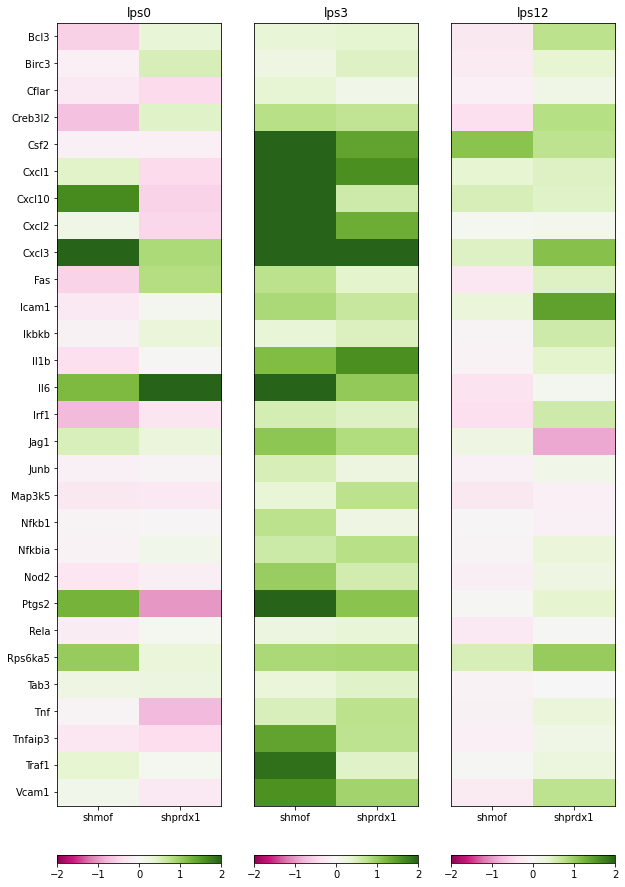

In [17]:
previous_names = np.array([])
df_to_write = pd.DataFrame()
fig, ax = plt.subplots(ncols=3)
for i, (k, v) in enumerate(all_dfs.items()):
    df_to_write[k+"_shmof"] = v[0]["log2FoldChange"].values
    df_to_write[k+"_shprdx1"] = v[1]["log2FoldChange"].values

    values = np.array([v[0]["log2FoldChange"].values, v[1]["log2FoldChange"].values])
    comparison = v[0]["external_gene_name"].values == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    
    previous_names = v[0]["external_gene_name"].values
    comparison = previous_names == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    im = ax[i].imshow(values.transpose(), interpolation='nearest', aspect='auto', vmin = -2,
                      vmax = 2, cmap='PiYG')
    
    if i == 0:
        ax[i].set_yticks(np.arange(len(previous_names)))
        ax[i].set_yticklabels(previous_names)
    else:
        ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(2))
    ax[i].set_xticklabels(["shmof", "shprdx1"])
    ax[i].set_title(k)
    fig.colorbar(im, ax = ax[i], orientation='horizontal', pad=0.05)
fig.set_size_inches(10,18)
plt.show()
fig.savefig(os.path.join(out_path, "tnf_pathway.pdf"))
df_to_write["gene_name"] = previous_names
df_to_write.to_csv(os.path.join(out_path, "tnf_pathway.tsv"), sep = "\t", index = None)

In [18]:
# 3) steroid pathway
steroid_ensemble = gene_name_df.loc[gene_name_df["external_gene_name"].str.upper().isin(steroid_pathway)]
steroid_ensemble = steroid_ensemble[["ensembl_gene_id", "ensembl_gene_id_version", "external_gene_name"]]
print(len(steroid_ensemble))

8


In [19]:
all_dfs = dict()
for time in ["lps0", "lps3", "lps12"]:
    for cond in ["shmof", "shprdx1"]:
        for file in glob.glob(os.path.join(in_path, "ddr_"+time+"_shctrl_"+time+"_"+cond+"*.tsv")):
            print(file)
            df = pd.read_csv(file, sep = "\t")
            df['ensembl_gene_id'] = df['gene_id'].str.split('.', 1).str[0]
            df = df.merge(steroid_ensemble, how = "inner", on = "ensembl_gene_id")
            df.sort_values(by=['external_gene_name'], inplace = True)
            if time not in all_dfs.keys():
                all_dfs[time] = []            
            all_dfs[time].append(df)

/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps0_shctrl_lps0_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps3_shctrl_lps3_shprdx1.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shmof.filtered.tsv
/data/processing1/leily/deseq_pairwise/fdr0.05/ddr_lps12_shctrl_lps12_shprdx1.filtered.tsv


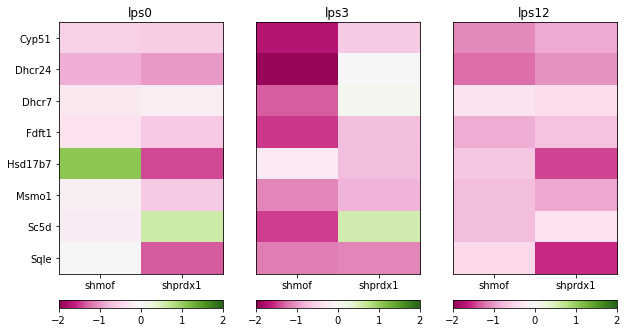

In [20]:
previous_names = np.array([])
df_to_write = pd.DataFrame()
fig, ax = plt.subplots(ncols=3)
for i, (k, v) in enumerate(all_dfs.items()):
    df_to_write[k+"_shmof"] = v[0]["log2FoldChange"].values
    df_to_write[k+"_shprdx1"] = v[1]["log2FoldChange"].values

    values = np.array([v[0]["log2FoldChange"].values, v[1]["log2FoldChange"].values])
    comparison = v[0]["external_gene_name"].values == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    
    previous_names = v[0]["external_gene_name"].values
    comparison = previous_names == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    im = ax[i].imshow(values.transpose(), interpolation='nearest', aspect='auto', vmin = -2,
                      vmax = 2, cmap='PiYG')
    
    if i == 0:
        ax[i].set_yticks(np.arange(len(previous_names)))
        ax[i].set_yticklabels(previous_names)
    else:
        ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(2))
    ax[i].set_xticklabels(["shmof", "shprdx1"])
    ax[i].set_title(k)
    fig.colorbar(im, ax = ax[i], orientation='horizontal', pad=0.08)
fig.set_size_inches(10,6)
plt.show()
fig.savefig(os.path.join(out_path, "steroid_pathway.pdf"))
df_to_write["gene_name"] = previous_names
df_to_write.to_csv(os.path.join(out_path, "steroid_pathway.tsv"), sep = "\t", index = None)

In [7]:
# export DEGs with log2FC in LPS12 up enriched pathways- Cell cycle

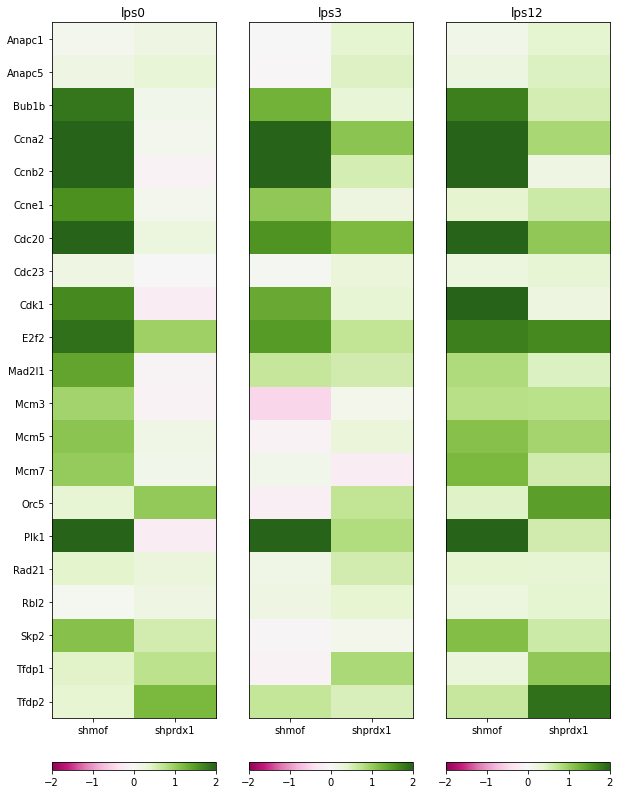

In [11]:
cellcycle_ensemble = gene_name_df.loc[gene_name_df["external_gene_name"].str.upper().isin(cell_cycle_pathway)]

all_dfs = dict()
for time in ["lps0", "lps3", "lps12"]:
    for cond in ["shmof", "shprdx1"]:
        for file in glob.glob(os.path.join(in_path, "ddr_"+time+"_shctrl_"+time+"_"+cond+"*.tsv")):
            df = pd.read_csv(file, sep = "\t")
            df['ensembl_gene_id'] = df['gene_id'].str.split('.', 1).str[0]
            df = df.merge(cellcycle_ensemble, how = "inner", on = "ensembl_gene_id")
            df.sort_values(by=['external_gene_name'], inplace = True)
            if time not in all_dfs.keys():
                all_dfs[time] = []            
            all_dfs[time].append(df)

previous_names = np.array([])
df_to_write = pd.DataFrame()
fig, ax = plt.subplots(ncols=3)
for i, (k, v) in enumerate(all_dfs.items()):
    df_to_write[k+"_shmof"] = v[0]["log2FoldChange"].values
    df_to_write[k+"_shprdx1"] = v[1]["log2FoldChange"].values

    values = np.array([v[0]["log2FoldChange"].values, v[1]["log2FoldChange"].values])
    comparison = v[0]["external_gene_name"].values == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    
    previous_names = v[0]["external_gene_name"].values
    comparison = previous_names == v[1]["external_gene_name"].values
    equal_arrays = comparison.all()
    assert(equal_arrays == True)
    im = ax[i].imshow(values.transpose(), interpolation='nearest', aspect='auto', vmin = -2,
                      vmax = 2, cmap='PiYG')
    
    if i == 0:
        ax[i].set_yticks(np.arange(len(previous_names)))
        ax[i].set_yticklabels(previous_names)
    else:
        ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(2))
    ax[i].set_xticklabels(["shmof", "shprdx1"])
    ax[i].set_title(k)
    fig.colorbar(im, ax = ax[i], orientation='horizontal', pad=0.05)
fig.set_size_inches(10,16)
plt.show()
fig.savefig(os.path.join(out_path, "cellcycle_pathway.pdf"))
df_to_write["gene_name"] = previous_names
df_to_write.to_csv(os.path.join(out_path, "cellcycle_pathway.tsv"), sep = "\t", index = None)